In [1]:
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
!wget $url/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget $url/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib

Selecting previously unselected package libta-lib0.
(Reading database ... 160690 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.2) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

     |████████████████████████████████| 276kB 18.2MB/s 
  Created wheel for ta-lib: filename=TA_Lib-0.4.19-cp37-cp37m-linux_x86_64.whl size=1438000 sha256=3f57c2c546c6b8c66f6d1449d83e80c68f9da81e3fe61a087283dccd4b0d45f7
  Stored in directory: /root/.cache/pip/wheels/a3/f6/12/3d1ccd06caadd8fa47e016991dd0d27f1163bb260f1854e2ff
Successfully built ta-lib


In [2]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 8.9MB/s 


In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import talib as ta
import tensorflow as tf
import kerastuner as kt

from statsmodels.graphics.tsaplots import plot_pacf

from kerastuner.engine.hyperparameters import HyperParameters
from kerastuner.tuners import RandomSearch, Hyperband

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Bidirectional, Attention, RepeatVector, TimeDistributed, BatchNormalization, dot, Concatenate, Activation
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam

sns.set()

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPU


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
stock=pd.read_csv('/content/drive/MyDrive/aapl_wmb.csv',parse_dates=['Date'])

In [60]:
aapl=stock[stock['ticker']=='AAPL']

In [8]:
wmb=stock[stock['ticker']=='WMB']

In [61]:
aapl.set_index('Date',inplace=True)
aapl.drop(columns=['ticker'],inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [62]:
wmb.set_index('Date',inplace=True)
wmb.drop(columns=['ticker'],inplace=True)

KeyError: ignored

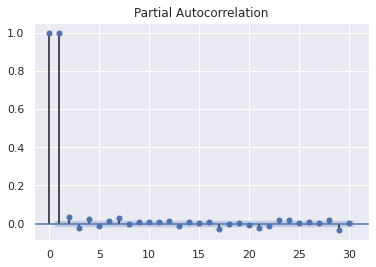

In [63]:
plot_pacf(aapl['Close'],lags=30);

In [64]:
for i in range(8):
    aapl['close'+str(i)]=aapl['Close'].shift(i)-aapl['Close'].shift(i+1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [65]:
wmb

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1981-12-31,3.437749,3.507908,3.367591,3.414363,0.793259,521946.0
1982-01-04,3.414363,3.429954,3.383182,3.429954,0.796881,224493.0
1982-01-05,3.305228,3.398773,3.196094,3.274047,0.760659,686307.0
1982-01-06,3.227275,3.274047,3.180503,3.180503,0.738926,1118455.0
1982-01-07,3.164912,3.227275,3.086959,3.164912,0.735304,831425.0
...,...,...,...,...,...,...
2021-04-09,23.620001,23.730000,23.360001,23.600000,23.600000,7007500.0
2021-04-12,23.709999,23.830000,23.400000,23.450001,23.450001,4012400.0
2021-04-13,23.440001,23.790001,23.280001,23.700001,23.700001,7022700.0


In [66]:
#aapl['atr']=ta.ATR(aapl['High'],aapl['Low'],aapl['Close'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [67]:
aapl['rsi']=ta.RSI(aapl['Close'],timeperiod=14)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [68]:
aapl['obv']=ta.OBV(aapl['Close'],aapl['Volume'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [69]:
# aapl['sma30']=ta.SMA(aapl['Close'],timeperiod=30)
# aapl['sma200']=ta.SMA(aapl['Close'],timeperiod=200)

In [70]:
# aapl['ema30']=ta.EMA(aapl['Close'],timeperiod=30)
# aapl['ema200']=ta.EMA(aapl['Close'],timeperiod=200)

In [72]:
aapl=aapl[aapl.index.year>2010]

In [73]:
aapl.drop(columns=['Open','High','Low','Close','Adj Close','Volume'],inplace=True)

In [74]:
aapl.dropna(inplace=True)

In [75]:
aapl

,close0,close1,close2,close3,close4,close5,close6,close7,atr,rsi,obv
Date,,,,,,,,,,,
2011-01-03,0.250357,-0.039286,-0.058214,-0.006429,0.028215,0.038570,-0.055714,0.034286,0.138165,66.748139,1.587472e+11
2011-01-04,0.061429,0.250357,-0.039286,-0.058214,-0.006429,0.028215,0.038570,-0.055714,0.139393,68.723201,1.590563e+11
2011-01-05,0.096785,0.061429,0.250357,-0.039286,-0.058214,-0.006429,0.028215,0.038570,0.141783,71.586740,1.593118e+11
2011-01-06,-0.009642,0.096785,0.061429,0.250357,-0.039286,-0.058214,-0.006429,0.028215,0.137651,70.890437,1.590114e+11
2011-01-07,0.085357,-0.009642,0.096785,0.061429,0.250357,-0.039286,-0.058214,-0.006429,0.139171,73.360785,1.593233e+11
...,...,...,...,...,...,...,...,...,...,...,...
2021-04-09,2.639999,2.459999,1.690002,0.309998,2.900002,0.849998,2.250000,-1.489998,3.071296,66.734199,1.596901e+11
2021-04-12,-1.759995,2.639999,2.459999,1.690002,0.309998,2.900002,0.849998,2.250000,3.021203,62.163856,1.595987e+11
2021-04-13,3.189987,-1.759995,2.639999,2.459999,1.690002,0.309998,2.900002,0.849998,3.049688,66.625341,1.596900e+11


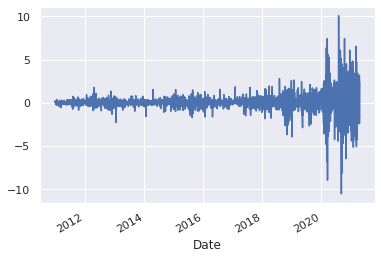

In [76]:
aapl['close0'].plot()

In [77]:
aapl

,close0,close1,close2,close3,close4,close5,close6,close7,atr,rsi,obv
Date,,,,,,,,,,,
2011-01-03,0.250357,-0.039286,-0.058214,-0.006429,0.028215,0.038570,-0.055714,0.034286,0.138165,66.748139,1.587472e+11
2011-01-04,0.061429,0.250357,-0.039286,-0.058214,-0.006429,0.028215,0.038570,-0.055714,0.139393,68.723201,1.590563e+11
2011-01-05,0.096785,0.061429,0.250357,-0.039286,-0.058214,-0.006429,0.028215,0.038570,0.141783,71.586740,1.593118e+11
2011-01-06,-0.009642,0.096785,0.061429,0.250357,-0.039286,-0.058214,-0.006429,0.028215,0.137651,70.890437,1.590114e+11
2011-01-07,0.085357,-0.009642,0.096785,0.061429,0.250357,-0.039286,-0.058214,-0.006429,0.139171,73.360785,1.593233e+11
...,...,...,...,...,...,...,...,...,...,...,...
2021-04-09,2.639999,2.459999,1.690002,0.309998,2.900002,0.849998,2.250000,-1.489998,3.071296,66.734199,1.596901e+11
2021-04-12,-1.759995,2.639999,2.459999,1.690002,0.309998,2.900002,0.849998,2.250000,3.021203,62.163856,1.595987e+11
2021-04-13,3.189987,-1.759995,2.639999,2.459999,1.690002,0.309998,2.900002,0.849998,3.049688,66.625341,1.596900e+11


In [78]:
aapl['target']=aapl['close0'].map(lambda x: 1 if x>0 else 0)

In [79]:
aapl.corr()[['target','close1']].sort_values(by='target')

,target,close1
close1,-0.050547,1.000000
close6,-0.026244,0.002320
atr,-0.007367,0.013787
close3,0.001746,0.033842
close5,0.013745,0.000595
close2,0.016440,-0.107449
close7,0.028360,-0.069772
close4,0.030404,-0.015334
obv,0.055699,0.037364
rsi,0.287732,0.208911


In [81]:
X=aapl.drop([i for i in aapl.columns if ('close' in i) and (i!='close0') or (i=='target')],axis=1)
y=aapl[[i for i in aapl.columns if ('close' in i) and (i!='close0')]]
y_class=aapl['target']

In [82]:
X_train,X_test,y_train,y_test,y_class_train,y_class_test = train_test_split(X,y,y_class,train_size=0.8,shuffle=False)

In [83]:
mm=MinMaxScaler()
X_train=mm.fit_transform(X_train)
X_test=mm.transform(X_test)

In [84]:
# def batch_generator(X, y, y_cat, batch_size, length):
#   X_batch=np.array([])
#   for i in range(batch_size):
#     X_batch=np.append(X_batch,X[i:i+length])
#   X_batch=X_batch.reshape(batch_size,length,X.shape[1])
#   y1_batch=np.array(y[length:length+batch_size])
#   y2_batch=np.array(y_cat[length:length+batch_size])

#   yield (X_batch, {'out_price': y1_batch, 'out_buy': y2_batch})

In [85]:
# train_gen=batch_generator(X_train,y_train,y_class_train,64,30)
# test_gen=batch_generator(X_test,y_test,y_class_test,64,30)

In [86]:
def sequence_generator(X, y, y_cat, length):
  X_seq=np.array([])
  for i in range(len(X)-length):
    X_seq=np.append(X_seq,X[i:i+length])
  X_seq=X_seq.reshape(X.shape[0]-length,length,X.shape[1])
  y_seq=np.array(y[length:])
  y_class_seq=np.array(y_cat[length:])

  return X_seq, y_seq, y_class_seq

In [87]:
input_length=30

In [88]:
X_train_seq, y_train_seq, y_class_train_seq= sequence_generator(X_train,y_train,y_class_train,input_length)

In [89]:
X_test_seq, y_test_seq, y_class_test_seq= sequence_generator(X_test,y_test,y_class_test,input_length)

In [90]:
# def build_price_model(hp):
#   input_train = Input(shape=(X_train_seq.shape[1],X_train_seq.shape[2]))
#   input_lstm= Bidirectional(LSTM(
#       units=hp.Int('input_lstm',min_value=32,max_value=512,step=32),
#       return_sequences=True))(input_train)
#   input_lstm2 = Bidirectional(LSTM(
#       units=hp.Int('input_lstm2',min_value=32,max_value=512,step=32),
#   ))(input_lstm)
#   hidden1 = Dense(
#       units=hp.Int('hidden1',min_value=32,max_value=512,step=32),
#   )(input_lstm2)
#   drop1 = Dropout(0.2)(hidden1)
#   hidden2 = Dense(
#       hp.Int('hidden2',min_value=32,max_value=512,step=32)
#   )(drop1)


#   decoder_input = RepeatVector(y_train_seq.shape[1])(hidden2)
#   price_lstm = LSTM(
#       hp.Int('price_lstm',min_value=32,max_value=512,step=32),
#       return_sequences=True)(decoder_input)
#   price_lstm2 =Bidirectional(LSTM(
#       hp.Int('price_lstm2',min_value=32,max_value=512,step=32),
#       return_sequences=True))(price_lstm)
#   out_price = TimeDistributed(Dense(1),name='out_price')(price_lstm2)

#   model= Model(inputs=input_train,outputs=out_price)

#   model.compile(loss='mse', optimizer='adam')

#   return model

In [91]:
# tuner_price= kt.RandomSearch(
#     build_price_model,
#     objective="val_loss",
#     max_trials=10,
#     executions_per_trial=3,
#     directory='/content/drive/MyDrive/',
#     project_name='hp_price_model')

In [92]:
# early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [93]:
# tuner_price.search(X_train_seq, y_train_seq, epochs=50, validation_split=0.2, callbacks=[early_stop])

In [94]:
# best_price_hp=tuner_price.get_best_hyperparameters()[0]

In [95]:
# best_price_hp.get('input_lstm'),best_price_hp.get('input_lstm2'),best_price_hp.get('hidden1'),best_price_hp.get('hidden2'),best_price_hp.get('price_lstm'),best_price_hp.get('price_lstm2')

In [96]:
# def build_buy_model(hp):
#   input_train = Input(shape=(X_train_seq.shape[1],X_train_seq.shape[2]))
#   input_lstm= Bidirectional(LSTM(
#       units=hp.Int('input_lstm',min_value=32,max_value=512,step=32),
#       return_sequences=True))(input_train)
#   input_lstm2 = Bidirectional(LSTM(
#       units=hp.Int('input_lstm2',min_value=32,max_value=512,step=32),
#   ))(input_lstm)
#   hidden1 = Dense(
#       units=hp.Int('hidden1',min_value=32,max_value=512,step=32),
#   )(input_lstm2)
#   drop1 = Dropout(0.2)(hidden1)
#   hidden2 = Dense(
#       hp.Int('hidden2',min_value=32,max_value=512,step=32)
#   )(drop1)

#   drop2 = Dropout(0.2)(hidden2)
#   buy1 = Dense(hp.Int('buy1',min_value=10,max_value=100,step=10), activation='relu')(drop2)
#   drop3 = Dropout(0.2)(buy1)
#   buy2 = Dense(hp.Int('buy2',min_value=10,max_value=100,step=10),activation='relu')(drop3)
#   out_clas = Dense(1, activation='sigmoid',name='out_buy')(buy2)

#   model= Model(inputs=input_train,outputs=out_clas)

#   model.compile(loss='binary_crossentropy', optimizer='adam')

#   return model

In [97]:
# tuner_buy= kt.RandomSearch(
#     build_buy_model,
#     objective="val_loss",
#     max_trials=10,
#     executions_per_trial=3,
#     directory='/content/drive/MyDrive/',
#     project_name='hp_buy_model')

In [98]:
# tuner_buy.search(X_train_30, y_class_train, epochs=50, validation_split=0.2, callbacks=[early_stop])

In [99]:
# best_buy_hp=tuner_buy.get_best_hyperparameters()[0]

In [100]:
# best_buy_hp.get('input_lstm'),best_buy_hp.get('input_lstm2'),best_buy_hp.get('hidden1'),best_buy_hp.get('hidden2'),best_buy_hp.get('buy1'),best_buy_hp.get('buy2')

In [101]:
input_train = Input(shape=(X_train_seq.shape[1],X_train_seq.shape[2]))
input_lstm= Bidirectional(LSTM(256,return_sequences=True))(input_train)
input_lstm2 = Bidirectional(LSTM(128))(input_lstm)
hidden1 = Dense(64,activation='relu')(input_lstm2)
hidden2 = Dense(64,activation='relu')(hidden1)

In [102]:
decoder = Dense(32, activation='relu')(hidden2)
decoder_input = RepeatVector(y_train_seq.shape[1])(decoder)
price_lstm = Bidirectional(LSTM(128,return_sequences=True))(decoder_input)
price_lstm2 = Bidirectional(LSTM(256,return_sequences=True))(price_lstm)
out_price = TimeDistributed(Dense(1),name='out_price')(price_lstm2)

In [103]:
buy1 = Dense(32, activation='relu')(hidden2)
drop1 = Dropout(0.2)(buy1)
buy2 = Dense(16,activation='relu')(drop1)
buy3 = Dense(8, activation='relu')(buy2)
out_clas = Dense(1, activation='sigmoid',name='out_buy')(buy2)

In [104]:
model= Model(inputs=input_train,outputs=[out_price,out_clas])

In [107]:
checkpoint_file='/content/drive/MyDrive/lstm_stack'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_file,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


In [108]:
losses={
    'out_price':'mse',
    'out_buy':'binary_crossentropy'
}

weights={'out_price':1,'out_buy':1}


model.compile(loss=losses,
               loss_weights=weights,
               optimizer='adam',
               metrics={
                   'out_price':['mae'],
                   'out_buy':['acc']
                   })

In [109]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 30, 4)]      0                                            
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 30, 512)      534528      input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) (None, 256)          656384      bidirectional_4[0][0]            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 64)           16448       bidirectional_5[0][0]            
____________________________________________________________________________________________

In [110]:
history=model.fit(
    X_train_seq,{'out_price':y_train_seq,
                'out_buy':y_class_train_seq
                },
    validation_data=(X_test_seq,{'out_price':y_test_seq,
                                'out_buy':y_class_test_seq
                                }),
    epochs=100,
    callbacks=[model_checkpoint_callback],
    shuffle=False,
    verbose=1)

Epoch 1/100
64/64 [==============================] - 44s 65ms/step - loss: 0.8096 - out_price_loss: 0.1145 - out_buy_loss: 0.6950 - out_price_mae: 0.2357 - out_buy_acc: 0.4715 - val_loss: 5.3661 - val_out_price_loss: 4.6754 - val_out_buy_loss: 0.6908 - val_out_price_mae: 1.4658 - val_out_buy_acc: 0.5389
Epoch 2/100
64/64 [==============================] - 2s 24ms/step - loss: 0.8068 - out_price_loss: 0.1134 - out_buy_loss: 0.6934 - out_price_mae: 0.2333 - out_buy_acc: 0.5157 - val_loss: 5.3691 - val_out_price_loss: 4.6779 - val_out_buy_loss: 0.6912 - val_out_price_mae: 1.4661 - val_out_buy_acc: 0.5389
Epoch 3/100
64/64 [==============================] - 2s 24ms/step - loss: 0.8053 - out_price_loss: 0.1127 - out_buy_loss: 0.6926 - out_price_mae: 0.2328 - out_buy_acc: 0.5160 - val_loss: 5.3848 - val_out_price_loss: 4.6950 - val_out_buy_loss: 0.6898 - val_out_price_mae: 1.4696 - val_out_buy_acc: 0.5389
Epoch 4/100
64/64 [==============================] - 2s 24ms/step - loss: 0.8065 - out_

In [111]:
model.load_weights('/content/drive/MyDrive/lstm_stack')

In [116]:
predict=pd.DataFrame(model.predict(X_test_seq)[0].reshape(X_test_seq.shape[0],7),index=y_test.index[input_length:],columns=y_test.columns[:7])

In [117]:
predict['pred_vol']=predict.apply(np.std,axis=1)

In [118]:
y_test['actual_vol']=y_test.apply(np.std,axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


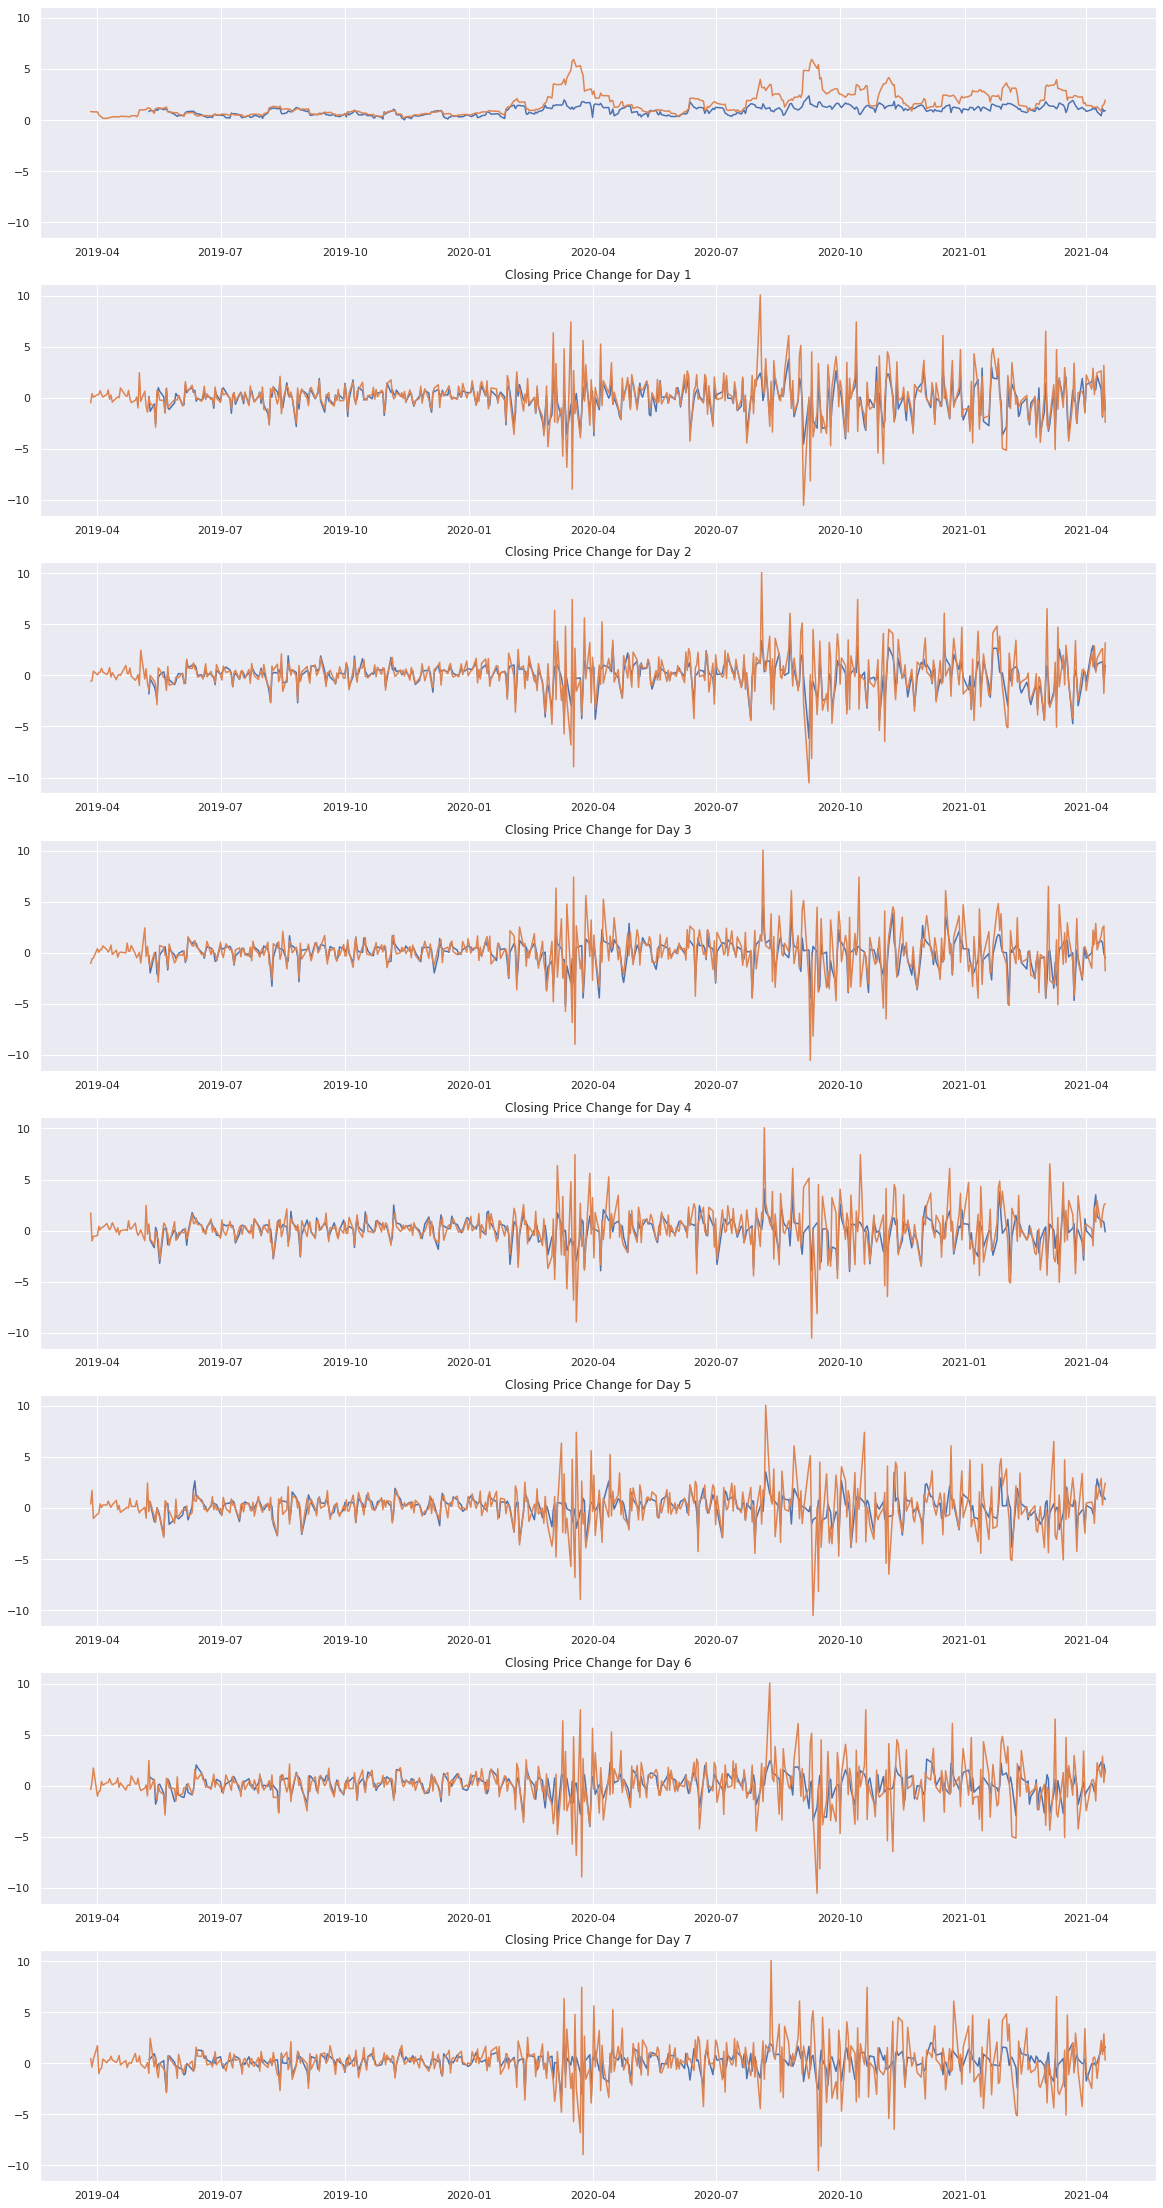

In [119]:
fig,axes=plt.subplots(8,1,sharey=True,figsize=(20,40))
axes[0].plot(predict['pred_vol'])
axes[0].plot(y_test['actual_vol'])

for i in range(1,8):
  axes[i].plot(predict['close'+str(i)])
  axes[i].plot(y_test['close'+str(i)])
  axes[i].title.set_text('Closing Price Change for Day '+str(i))

In [120]:
buy_predict=np.array([1 if i>=0.5 else 0 for i in model.predict(X_test_seq)[1]])

In [121]:
confusion_matrix(y_class_test_seq,buy_predict)

array([[101, 124],
       [114, 149]])

In [158]:
input_price = Input(shape=(X_train_seq.shape[1],X_train_seq.shape[2]))

input_lstm= Bidirectional(LSTM(256,return_sequences=True))(input_price)

encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(50,
                                                       return_state=True,
                                                       return_sequences=True
)(input_lstm)

encoder_last_h = BatchNormalization()(encoder_last_h)
encoder_last_c = BatchNormalization()(encoder_last_c)

decoder_input = RepeatVector(y_train_seq.shape[1])(encoder_last_h)

decoder_stack_h = LSTM(
    50,
    return_state=False,
    return_sequences=True
)(decoder_input, initial_state=[encoder_last_h,encoder_last_c])

atten1 = dot([decoder_stack_h,encoder_stack_h],axes=[2,2])
atten1 = Activation('softmax')(atten1)

atten2 = dot([atten1,encoder_stack_h], axes=[2,1])
atten2 = BatchNormalization(momentum=0.6)(atten2)

lstm_decoder=Bidirectional(LSTM(
    100,
    return_sequences=True
))(atten2)

out = TimeDistributed(Dense(1),name='out_price')(lstm_decoder)

buy1 = Dense(32, activation='relu')(encoder_last_h)
drop1 = Dropout(0.2)(buy1)
buy2 = Dense(16,activation='relu')(drop1)
buy3 = Dense(8)(buy2)
out_clas = Dense(1, activation='sigmoid',name='out_buy')(buy2)

model_atten= Model(inputs=input_price,outputs=[out, out_clas])

losses={
    'out_price':'mse',
    'out_buy':'binary_crossentropy'
}

weights={
    'out_price':1,
    'out_buy':1}

model_atten.compile(loss=losses,
              loss_weights=weights,
              optimizer='adam',
              metrics={
                   'out_price':['mae'],
                   'out_buy':['acc']
                   })

In [159]:
model_atten.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 30, 4)]      0                                            
__________________________________________________________________________________________________
bidirectional_27 (Bidirectional (None, 30, 512)      534528      input_14[0][0]                   
__________________________________________________________________________________________________
lstm_50 (LSTM)                  [(None, 30, 50), (No 112600      bidirectional_27[0][0]           
__________________________________________________________________________________________________
batch_normalization_24 (BatchNo (None, 50)           200         lstm_50[0][1]                    
____________________________________________________________________________________________

In [160]:
checkpoint_file='/content/drive/MyDrive/model_atten'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_file,
    save_weights_only=True,
    monitor='val_loss',
    mode='max',
    save_best_only=True)

In [161]:
model_atten.fit(X_train_seq,{'out_price':y_train_seq,'out_buy':y_class_train_seq},
    validation_data=(X_test_seq,{'out_price':y_test_seq,'out_buy':y_class_test_seq}),
    epochs=100,
    callbacks=[model_checkpoint_callback],
    verbose=1)

Epoch 1/100
64/64 [==============================] - 11s 49ms/step - loss: 0.9458 - out_price_loss: 0.2209 - out_buy_loss: 0.7249 - out_price_mae: 0.3167 - out_buy_acc: 0.4982 - val_loss: 5.2449 - val_out_price_loss: 4.5542 - val_out_buy_loss: 0.6907 - val_out_price_mae: 1.4460 - val_out_buy_acc: 0.5389
Epoch 2/100
64/64 [==============================] - 1s 20ms/step - loss: 0.8885 - out_price_loss: 0.1908 - out_buy_loss: 0.6977 - out_price_mae: 0.2898 - out_buy_acc: 0.5187 - val_loss: 5.2849 - val_out_price_loss: 4.5923 - val_out_buy_loss: 0.6926 - val_out_price_mae: 1.4720 - val_out_buy_acc: 0.5492
Epoch 3/100
64/64 [==============================] - 1s 20ms/step - loss: 0.8690 - out_price_loss: 0.1755 - out_buy_loss: 0.6934 - out_price_mae: 0.2831 - out_buy_acc: 0.5144 - val_loss: 5.2366 - val_out_price_loss: 4.5459 - val_out_buy_loss: 0.6907 - val_out_price_mae: 1.4692 - val_out_buy_acc: 0.5389
Epoch 4/100
64/64 [==============================] - 1s 20ms/step - loss: 0.8506 - out_

In [162]:
model_atten.load_weights('/content/drive/MyDrive/model_atten')

In [163]:
predict_atten=pd.DataFrame(model_atten.predict(X_test_seq)[0].reshape(X_test_seq.shape[0],7),index=y_test.index[input_length:],columns=y_test.columns[:7])

In [164]:
predict_atten['pred_vol']=predict_atten.apply(np.std,axis=1)

In [165]:
predict_atten['actual_vol']=y_test.apply(np.std,axis=1)

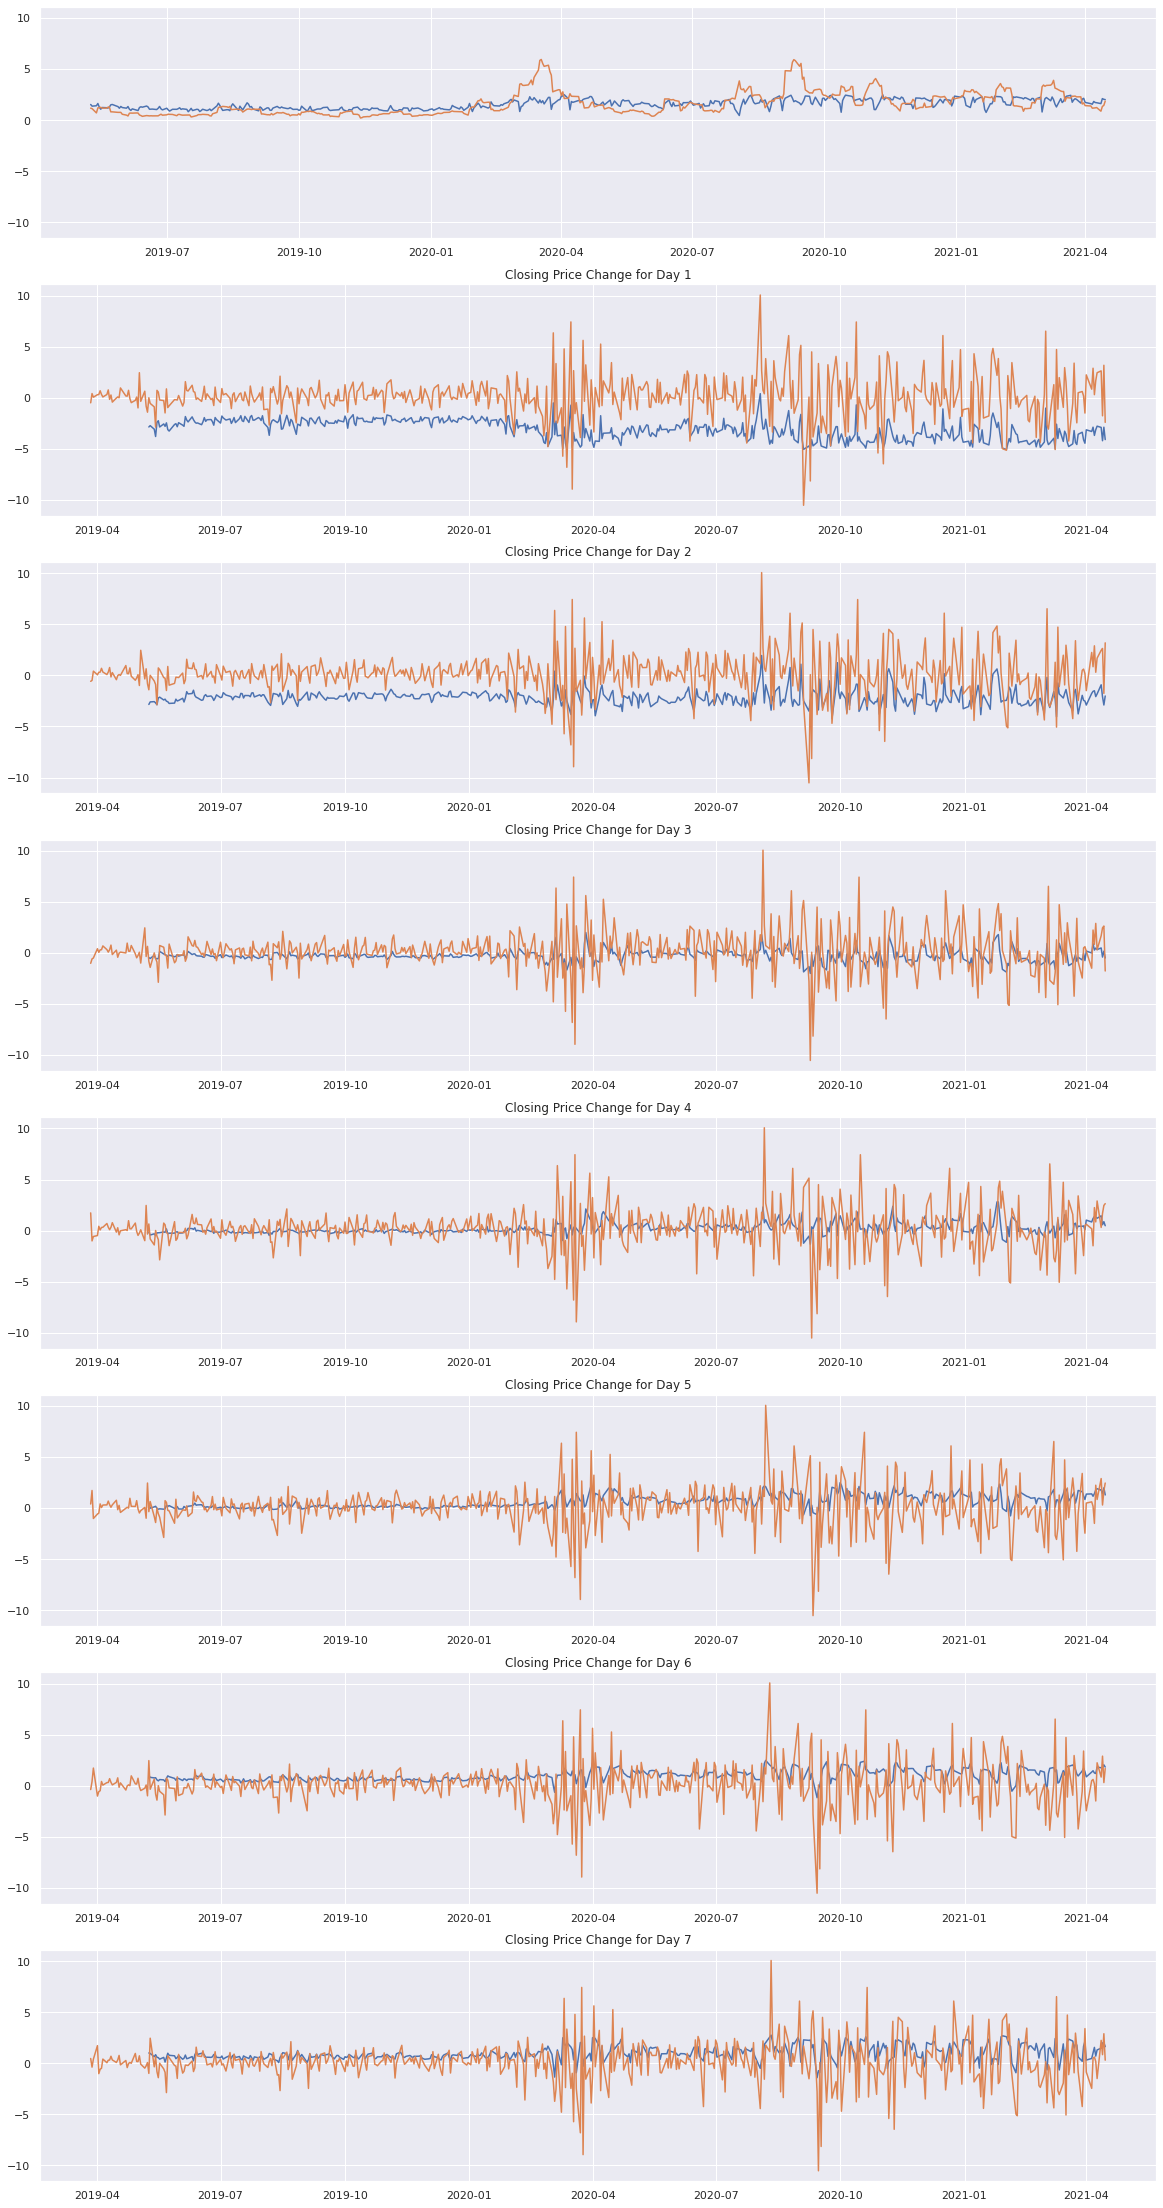

In [166]:
fig,axes=plt.subplots(8,1,sharey=True,figsize=(20,40))
axes[0].plot(predict_atten['pred_vol'])
axes[0].plot(predict_atten['actual_vol'])

for i in range(1,8):
  axes[i].plot(predict_atten['close'+str(i)])
  axes[i].plot(y_test['close'+str(i)])
  axes[i].title.set_text('Closing Price Change for Day '+str(i))

In [167]:
model_atten.predict(X_test_seq)

[array([[[-2.8511100e+00],
         [-2.8419456e+00],
         [-4.5323366e-01],
         ...,
         [ 4.9519268e-01],
         [ 1.0025755e+00],
         [ 1.0147601e+00]],
 
        [[-2.7215483e+00],
         [-2.5934365e+00],
         [-5.3618944e-01],
         ...,
         [-3.1698919e-03],
         [ 8.2342112e-01],
         [ 9.7057241e-01]],
 
        [[-3.0671098e+00],
         [-2.5661540e+00],
         [-2.2960752e-01],
         ...,
         [ 1.2932666e-01],
         [ 7.6891959e-01],
         [ 6.5092677e-01]],
 
        ...,
 
        [[-4.1989326e+00],
         [-2.0894313e+00],
         [-3.9695174e-01],
         ...,
         [ 1.4288810e+00],
         [ 1.7601749e+00],
         [ 1.9942404e+00]],
 
        [[-2.8726296e+00],
         [-2.8951912e+00],
         [ 1.7809196e-01],
         ...,
         [ 1.9897466e+00],
         [ 2.0467756e+00],
         [ 2.0074313e+00]],
 
        [[-4.0851903e+00],
         [-2.0141885e+00],
         [-4.8619723e-01],
         

In [170]:
class_predict_atten=np.array([1 if i>=0.5 else 0 for i in model_atten.predict(X_test_seq)[1]])

In [173]:
confusion_matrix(y_class_test[input_length:],class_predict_atten)

array([[ 18, 207],
       [ 17, 246]])